In [1]:
import numpy as np
import pandas as pd
import csv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!cp -r drive/MyDrive/smart-news-website/ /content/smart-news-website

In [4]:
%cd smart-news-website/

/content/smart-news-website


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
fake_news = pd.read_csv('/content/smart-news-website/FakeNews/Fake.csv')
true_news = pd.read_csv('/content/smart-news-website/FakeNews/True.csv')

In [ ]:
fake_news = fake_news['text']
true_news = true_news['text']

fake_news

0        Donald Trump just couldn t wish all Americans ...
1        House Intelligence Committee Chairman Devin Nu...
2        On Friday, it was revealed that former Milwauk...
3        On Christmas day, Donald Trump announced that ...
4        Pope Francis used his annual Christmas Day mes...
                               ...                        
23476    21st Century Wire says As 21WIRE reported earl...
23477    21st Century Wire says It s a familiar theme. ...
23478    Patrick Henningsen  21st Century WireRemember ...
23479    21st Century Wire says Al Jazeera America will...
23480    21st Century Wire says As 21WIRE predicted in ...
Name: text, Length: 23481, dtype: object

In [ ]:
from data import PreProcessor

preproc = PreProcessor()

fake_news = fake_news.apply(preproc.forward)
true_news = true_news.apply(preproc.forward)

fake_news.head()

0    donald trump wish americans happy new year lea...
1    house intelligence committee chairman devin nu...
2    friday -PRON- reveal former milwaukee sheriff ...
3    christmas day donald trump announce -PRON- wou...
4    pope francis use -PRON- annual christmas day m...
Name: text, dtype: object

In [ ]:
fake_news = pd.DataFrame(fake_news)
true_news = pd.DataFrame(true_news)

fake_news = fake_news.assign(is_fake = [1]*len(fake_news))
true_news = true_news.assign(is_fake = [0]*len(true_news))

In [ ]:
fake_news.head()

,text,is_fake
0,donald trump wish americans happy new year lea...,1
1,house intelligence committee chairman devin nu...,1
2,friday -PRON- reveal former milwaukee sheriff ...,1
3,christmas day donald trump announce -PRON- wou...,1
4,pope francis use -PRON- annual christmas day m...,1


In [ ]:
fake_news.to_csv('Fake_news_preprocessed.csv')
true_news.to_csv('True_news_preprocessed.csv')

## Checkpoint Preprocessing done

In [33]:
import pandas as pd
fake_news = pd.read_csv('/content/smart-news-website/Fake_news_preprocessed.csv')
true_news = pd.read_csv('/content/smart-news-website/True_news_preprocessed.csv')

In [34]:
fake_news.dropna(axis=0, inplace=True)
true_news.dropna(axis=0, inplace=True)

In [35]:
from sklearn.model_selection import train_test_split

train_fake_X, t_fake_X, train_fake_y, t_fake_y = train_test_split(fake_news.drop('is_fake', axis=1), fake_news['is_fake'], test_size=0.2, random_state=101)
test_fake_X, val_fake_X, test_fake_y, val_fake_y = train_test_split(t_fake_X, t_fake_y, test_size=0.5, random_state=101)

train_true_X, t_true_X, train_true_y, t_true_y = train_test_split(true_news.drop('is_fake', axis=1), true_news['is_fake'], test_size=0.2, random_state=101)
test_true_X, val_true_X, test_true_y, val_true_y = train_test_split(t_true_X, t_true_y, test_size=0.5, random_state=101)

In [36]:
# Joining fake and true dataframes

train_X = pd.concat([train_fake_X, train_true_X])
val_X = pd.concat([val_fake_X, val_true_X])
test_X = pd.concat([test_fake_X, test_true_X])

train_y = pd.concat([train_fake_y, train_true_y])
val_y = pd.concat([val_fake_y, val_true_y])
test_y = pd.concat([test_fake_y, test_true_y])

train_y = pd.DataFrame(train_y)
val_y = pd.DataFrame(val_y)
test_y = pd.DataFrame(test_y)

In [37]:
train_X = train_X['text']
val_X = val_X['text']
test_X = test_X['text']

In [38]:
train_X.shape

(35412,)

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features = 50000, lowercase=False, ngram_range=(1,2))
train_X_vec = vectorizer.fit_transform(train_X)
val_X_vec = vectorizer.transform(val_X)
test_X_vec = vectorizer.transform(test_X)

In [40]:
#import joblib

#joblib.dump(vectorizer, 'tfidf_for_fakenews.pkl')

In [41]:
train_X_vec[:2048].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
!pwd

/content/smart-news-website


In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model(nn.Module):
    
    def __init__(self, input_features=50000, hidden1=512, hidden2=128, hidden3=32, output_features=1):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_features, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.out = nn.Linear(hidden3, output_features)

    def forward(self, x):

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        
        return torch.sigmoid(x)

In [69]:
fake_model = Model()
fake_model.parameters

<bound method Module.parameters of Model(
  (fc1): Linear(in_features=50000, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)>

In [71]:
epochs = 10
learning_rate = 1e-3
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(fake_model.parameters(), lr = learning_rate)
batch_size = 1024

final_losses = []

for i in range(epochs):
    
    batch_idx = 0

    while (batch_idx+1)*batch_size < train_X_vec.shape[0]:
        
        batch_X = train_X_vec[batch_idx*batch_size:(batch_idx+1)*batch_size].toarray()
        batch_y = train_y[batch_idx*batch_size:(batch_idx+1)*batch_size]
        y_pred = fake_model.forward(torch.Tensor(batch_X))

        loss = loss_fn(y_pred, torch.Tensor(np.array(batch_y)))
        final_losses.append(loss)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_idx += 1
        del batch_X
        del batch_y

        if batch_idx%10 == 0:
            print(f'Epoch #{i+1}; Batch #{batch_idx+1}')

    if i%10 == 0:
        print(f'Epoch Number: {i+1}; Loss: {loss.item()}')
        

Epoch #1; Batch #11
Epoch #1; Batch #21
Epoch #1; Batch #31
Epoch Number: 1; Loss: 0.8484814763069153
Epoch #2; Batch #11
Epoch #2; Batch #21
Epoch #2; Batch #31
Epoch #3; Batch #11
Epoch #3; Batch #21
Epoch #3; Batch #31
Epoch #4; Batch #11
Epoch #4; Batch #21
Epoch #4; Batch #31
Epoch #5; Batch #11
Epoch #5; Batch #21
Epoch #5; Batch #31
Epoch #6; Batch #11
Epoch #6; Batch #21
Epoch #6; Batch #31
Epoch #7; Batch #11
Epoch #7; Batch #21
Epoch #7; Batch #31
Epoch #8; Batch #11
Epoch #8; Batch #21
Epoch #8; Batch #31
Epoch #9; Batch #11
Epoch #9; Batch #21
Epoch #9; Batch #31
Epoch #10; Batch #11
Epoch #10; Batch #21
Epoch #10; Batch #31
Epoch #11; Batch #11
Epoch #11; Batch #21
Epoch #11; Batch #31
Epoch Number: 11; Loss: 0.002064896747469902
Epoch #12; Batch #11
Epoch #12; Batch #21
Epoch #12; Batch #31
Epoch #13; Batch #11
Epoch #13; Batch #21
Epoch #13; Batch #31
Epoch #14; Batch #11
Epoch #14; Batch #21
Epoch #14; Batch #31
Epoch #15; Batch #11
Epoch #15; Batch #21
Epoch #15; Batch

In [72]:
torch.save(fake_model, 'fake_model_l.pt')

In [75]:
torch.save(fake_model.state_dict(), 'fake_model_state_dict.pt')

## Evaluation

Text(0, 0.5, 'Loss')

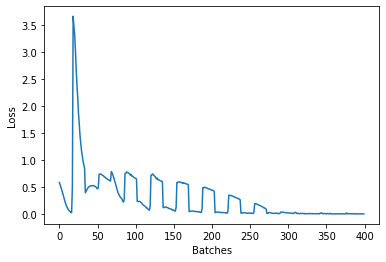

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.plot(range(len(final_losses[:400])), final_losses[:400])
plt.xlabel('Batches')
plt.ylabel('Loss')

In [95]:
y_pred = []

for i, data in enumerate(torch.Tensor(val_X_vec.toarray())):
    y_pred.append(int(fake_model(data)>0.5))

In [96]:
len(y_pred)

4428

In [97]:
from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(val_y, y_pred))

[[2087   55]
 [   5 2281]]


In [98]:
print(classification_report(val_y, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99      2142
           1       0.98      1.00      0.99      2286

    accuracy                           0.99      4428
   macro avg       0.99      0.99      0.99      4428
weighted avg       0.99      0.99      0.99      4428



In [99]:
y_pred = []

for i, data in enumerate(torch.Tensor(test_X_vec.toarray())):
    y_pred.append(int(fake_model(data)>0.5))

In [100]:
len(y_pred)

4427

In [102]:
print(confusion_matrix(test_y, y_pred))

[[2086   56]
 [  11 2274]]


In [103]:
print(classification_report(test_y, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2142
           1       0.98      1.00      0.99      2285

    accuracy                           0.98      4427
   macro avg       0.99      0.98      0.98      4427
weighted avg       0.99      0.98      0.98      4427

